# CW1--Decision Tree

#### Import the libraries

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import Counter, deque

## 1. Loading Data

In [2]:
def load_data(file_path: str) -> tuple[np.ndarray, np.ndarray]:
    file = np.loadtxt(file_path)
    labels = np.unique(file[:, -1])
    print(f"The shape of {file_path}: {file.shape}")
    print(f"The labels of {file_path}: {labels}")
    return file, labels

In [3]:
clean_file_path = 'wifi_db/clean_dataset.txt'
noisy_file_path = 'wifi_db/noisy_dataset.txt'
clean_data, clean_data_labels = load_data(clean_file_path)
noisy_data, noisy_data_labels = load_data(noisy_file_path)

The shape of wifi_db/clean_dataset.txt: (2000, 8)
The labels of wifi_db/clean_dataset.txt: [1. 2. 3. 4.]
The shape of wifi_db/noisy_dataset.txt: (2000, 8)
The labels of wifi_db/noisy_dataset.txt: [1. 2. 3. 4.]


The size of the data is 2000*8, which include 7 features and 1 label.

The labels are: 1, 2, 3, 4.

## 2. Creating Decision Tree
#### (1) Tree Node Class

In [4]:
class TreeNode:
    """
    Tree node class, which represents a node in the tree.
    """

    def __init__(self, leaf: bool = False, label: int = None, attr: int = None, value: float = None, depth=0):
        """
        Tree node constructor.
        Args:
            leaf: True if the node is a leaf node, False otherwise.
            label: The label of the leaf node.
            attr: The attribute of the node.
            value: The value of the attribute.
        """
        self.leaf = leaf
        self.label = label
        self.attr = attr
        self.value = value
        self.left = None
        self.right = None
        self.depth = depth

    def is_leaf(self):
        """
        Check if the node is a leaf node.
        Return:
            True if the node is a leaf node, False otherwise.
        """
        return self.leaf

#### (2) Calculate Entropy

In [5]:
def entropy(data: np.ndarray) -> float:
    """
    Calculate the entropy of the data.
    Args:
        data: The data to calculate the entropy of.
    Return:
        The entropy of the data.
    """
    labels = data[:, -1]
    total = len(labels)
    label_counts = Counter(labels)
    entropy = 0
    for label in label_counts:
        p = label_counts[label] / total
        entropy -= p * math.log2(p)
    return entropy

#### (3) Define Function _find\_split_

In [6]:
def find_split(data: np.ndarray) -> tuple[tuple[int, float], np.ndarray, np.ndarray]:
    """
    Find the best split for the data.
    Args:
        data: The data to find the best split for.
    Return:
        The best split attribute and value.
    """
    best_gain = 0                   # Best information gain
    split = None                    # Best split
    l_branch, r_branch = None, None # Left and right branches

    for attr in range(data.shape[1] - 1):
        sorted_attr = data[data[:, attr].argsort()] # Sort the attribute
        for i in range(1, len(sorted_attr)):
            left, right = sorted_attr[:i], sorted_attr[i:]  # Split the data
            if len(np.unique(left[:, -1])) > 1 and len(np.unique(right[:, -1])) > 1:    # Check if the split is valid
                H_all = entropy(data)    # Calculate the entropy of the data
                H_left = entropy(left)   # Calculate the entropy of the left branch
                H_right = entropy(right) # Calculate the entropy of the right branch

                gain = H_all - (len(left) / len(data)) * H_left - (len(right) / len(data)) * H_right    # Calculate the information gain

                if gain > best_gain:
                    best_gain = gain    # Update the best information gain
                    split = (attr, (sorted_attr[i - 1, attr] + sorted_attr[i, attr]) / 2)   # Update the best split
                    l_branch, r_branch = left, right    # Update the left and right branches
    return split, l_branch, r_branch

#### (4) Define Function _decision\_tree\_learning_

In [7]:
def decision_tree_learning(data: np.ndarray, depth: int = 0) -> tuple[TreeNode, int]:
    """
    Recursive function to learn the decision tree.
    Args:
        data: The data to learn the decision tree from.
        depth: The depth of the current node.
        
    Return:
        The root node of the decision tree
    """
    labels = data[:, -1]    # Get the labels of the data

    if len(set(labels)) == 1:   # If all labels are the same, return a leaf node
        return TreeNode(leaf=True, label=labels[0], depth=depth), depth

    split, l_branch, r_branch = find_split(data)    # Find the best split
    if split is None:   # If there is no split, return a leaf node
        # Return the most common label
        return TreeNode(leaf=True, label=Counter(labels).most_common(1)[0][0], depth=depth), depth

    # Create a new decision tree node
    node = TreeNode(leaf=False, attr=split[0], value=split[1], depth=depth)
    node.left, left_depth = decision_tree_learning(l_branch, depth + 1)    # Recursively learn the left branch
    node.right, right_depth = decision_tree_learning(r_branch, depth + 1)  # Recursively learn the right branch

    max_depth = max(left_depth, right_depth)    # Calculate the maximum depth

    return node, max_depth

#### (5) Tree Visualization

In [8]:
def plot_tree(node: TreeNode, depth: int = 0, max_depth: int = 5, x=0.5, y=1.0, x_space=0.5):
    """
    Plot the decision tree.
    Args:
        node: The root of the decision tree.
        depth: The depth of the current node.
        max_depth: The maximum depth to plot.
        x: The x position of the current node.
        y: The y position of the current node.
        x_space: The space between nodes
    """
    if depth >= max_depth or node is None:
        return
    
    if node.is_leaf():
        plt.text(x, y, f"Leaf: {node.label}", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    else:
        plt.text(x, y, f"X[{node.attr}] < {node.value:.2f}", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    y_new = y - 1 / max_depth   # Calculate the new y position

    if node.left is not None:
        x_left = x - x_space / (2 ** depth)   # Calculate the new x position for the left child
        plt.plot([x, x_left], [y, y_new], 'k-')    # Plot the edge
        plot_tree(node.left, depth + 1, max_depth, x_left, y_new, x_space)    # Recursively plot the left child

    if node.right is not None:
        x_right = x + x_space / (2 ** depth)    # Calculate the new x position for the right child
        plt.plot([x, x_right], [y, y_new], 'k-')    # Plot the edge
        plot_tree(node.right, depth + 1, max_depth, x_right, y_new, x_space)    # Recursively plot the right child

def visualize_tree(node: TreeNode, max_depth: int = 5):
    """
    Visualize the decision tree.
    Args:
        node: The root of the decision tree.
        max_depth: The maximum depth to visualize.
    """
    plt.figure(figsize=(24, 8))
    plt.axis('off')
    plot_tree(node, max_depth=max_depth)
    plt.show()

## 3. Evaluation
#### (1) Prediction

In [9]:
def predict(tree: TreeNode, data: np.ndarray) -> np.ndarray:
    """
    Recursively predict the label of the data.
    Args:
        tree: The decision tree.
        data: The data to predict the label of.
    Return:
        The predicted label of the data.
    """
    if tree.is_leaf():  # If the node is a leaf node, return the label
        return tree.label
    
    attr, value = tree.attr, tree.value   # Get the attribute and value of the node
    if data[attr] < value:  # If the data is less than the value, go left
        return predict(tree.left, data)
    else:   # If the data is greater than or equal to the value, go right
        return predict(tree.right, data)

#### (2) Evaluation

In [10]:
def evaluate(data: np.ndarray, tree: TreeNode) -> dict:
    """
    Evaluate the decision tree.
    Args:
        data: The data to evaluate the decision tree on.
        tree: The decision tree to evaluate.
    Return:
        The evaluation metrics.
    """
    predictions = [predict(tree, row[:-1]) for row in data]    # Predict the labels of the data
    ground_truth = data[:, -1]  # Get the ground truth labels

    accuracy = np.mean(predictions == ground_truth)   # Calculate the accuracy

    confusion_matrix = np.zeros((4, 4), dtype=int)   # Create the confusion matrix
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[int(gt) - 1, int(pred) - 1] += 1  # Update the confusion matrix
    
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)   # Calculate the precision
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)  # Calculate the recall
    f1 = 2 * precision * recall / (precision + recall)   # Calculate the F1 score

    return {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

#### (3) Cross Validation

In [11]:
def cross_validation(data: np.ndarray, k: int = 10, trained_tree: TreeNode = None) -> dict:
    """
    Perform k-fold cross validation.
    Args:
        data: The data to perform cross validation on.
        k: The number of folds.
    Return:
        A dictionary containing the metrics.
    """
    np.random.shuffle(data) # Shuffle the data
    fold_size = len(data) // k    # Calculate the fold size
    metrics = []    # List to store the metrics

    for i in range(k):  # Iterate over the folds
        test_data = data[i * fold_size: (i + 1) * fold_size]    # Get the test data
        train_data = np.concatenate([data[:i * fold_size], data[(i + 1) * fold_size:]])    # Get the train data
        tree = trained_tree if trained_tree is not None else decision_tree_learning(train_data)    # Learn the decision tree
        metrics.append(evaluate(test_data, tree))    # Evaluate the decision tree

    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in metrics]),
        'confusion_matrix': np.mean([m['confusion_matrix'] for m in metrics], axis=0),
        'precision': np.mean([m['precision'] for m in metrics], axis=0),
        'recall': np.mean([m['recall'] for m in metrics], axis=0),
        'f1': np.mean([m['f1'] for m in metrics], axis=0)
    }

    return avg_metrics

## 4. Pruning

In [12]:
def get_subtree_common(tree: TreeNode, data:np.ndarray) -> np.ndarray:
    """
    Filter data to get the samples of the subtree.
    Args:
        tree: The decision tree.
        data: The data to filter.
    Return:
        The filtered data.
    """
    subtree_data = []
    for sample in data:
        current_node = tree
        while current_node is not None:
            if current_node.is_leaf():  # If the node is a leaf, add the sample to the subtree data
                subtree_data.append(sample[-1])
                break   # Break the loop
            attr, value = current_node.attr, current_node.value
            if sample[attr] < value:
                current_node = current_node.left    # Go left
            else:
                current_node = current_node.right   # Go right
    
    subtree_data = np.array(subtree_data)    # Convert the list to a numpy array

    if len(subtree_data) > 0:
        majority_label = Counter(subtree_data).most_common(1)[0][0]   # Get the majority label
    else:
        majority_label = None
    return majority_label, subtree_data

def prune_tree(tree: TreeNode, train_data: np.ndarray, validation_data: np.ndarray) -> TreeNode:
    """
    Prune the decision tree.
    Args:
        tree: The decision tree to prune.
        train_data: The training data.
        validation_data: The validation data.
    Return:
        The pruned decision tree.
    """
    q = deque([tree])
    while q:
        node = q.popleft()
        
        if node.is_leaf():
            continue

        if node.left.is_leaf() and node.right.is_leaf():
            validation_error_before = sum(predict(tree, sample[:-1]) != sample[-1] for sample in validation_data)

            majority_label, _ = get_subtree_common(node, train_data) # Get the majority label
            original_left, original_right = node.left, node.right
            node.left, node.right = None, None
            node.leaf = True
            node.label = majority_label

            validation_error_after = sum(predict(tree, sample[:-1]) != sample[-1] for sample in validation_data)

            if validation_error_after > validation_error_before:
                node.left, node.right = original_left, original_right
                node.leaf = False
                node.label = None
        else:
            if node.left:
                q.append(node.left)
            if node.right:
                q.append(node.right)
    return tree

    

## 5. Testing

Max Depth: 9


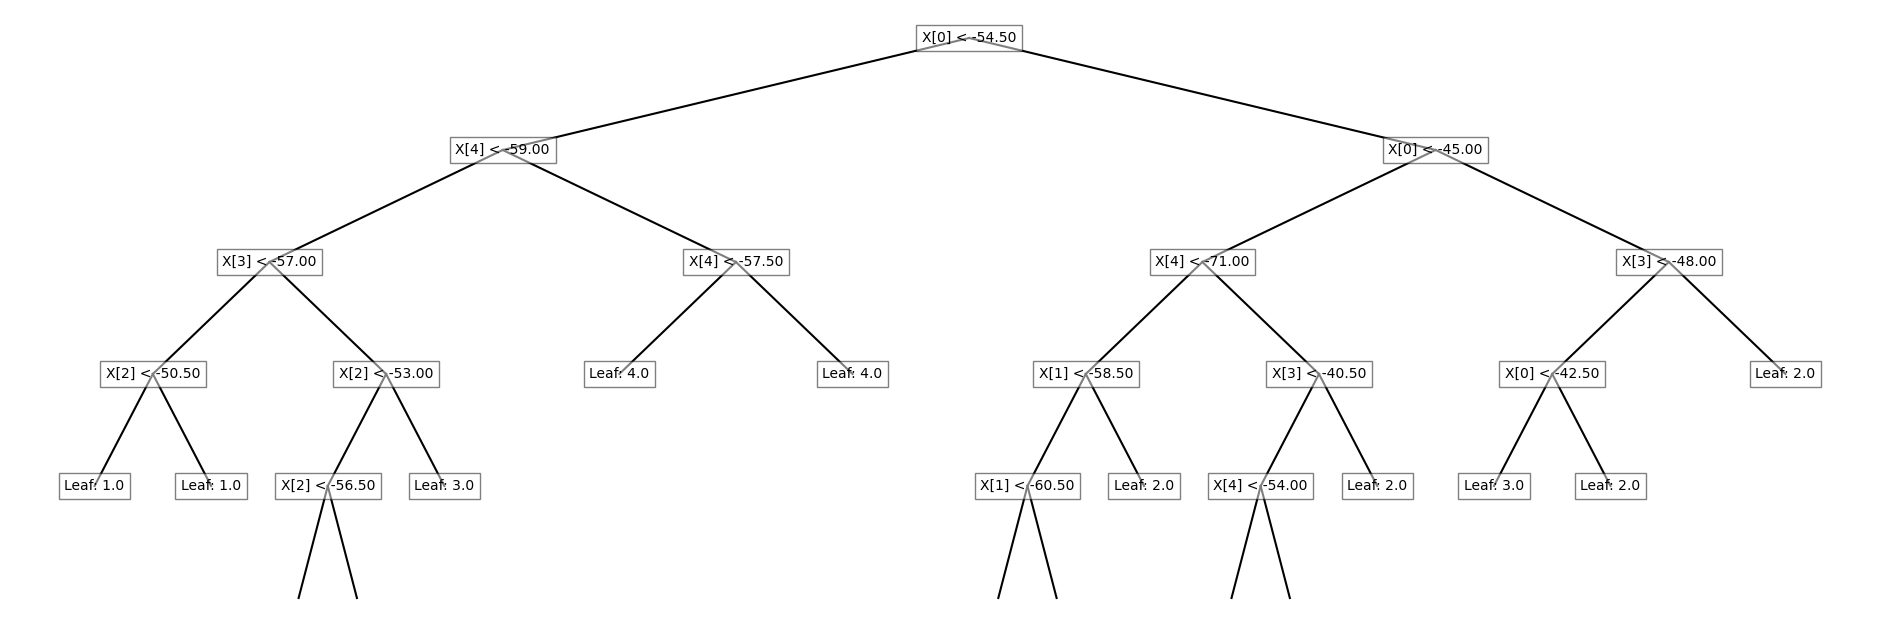

In [13]:
# split the data into training and validation sets
np.random.seed(12)
np.random.shuffle(clean_data)
train_size = int(0.8 * len(clean_data))
train_data, validation_data = clean_data[:train_size], clean_data[train_size:]

# train the decision tree
tree, max_depth = decision_tree_learning(train_data)
print(f"Max Depth: {max_depth}")
visualize_tree(tree, max_depth=5)

In [14]:
# evaluate the decision tree
metrics = evaluate(validation_data, tree)
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1: {metrics['f1']}")

Accuracy: 0.96
Confusion Matrix:
[[95  0  2  0]
 [ 0 97  8  0]
 [ 1  3 94  0]
 [ 1  0  0 99]]
Precision: [0.97938144 0.97       0.90384615 1.        ]
Recall: [0.97938144 0.92380952 0.95918367 0.99      ]
F1: [0.97938144 0.94634146 0.93069307 0.99497487]


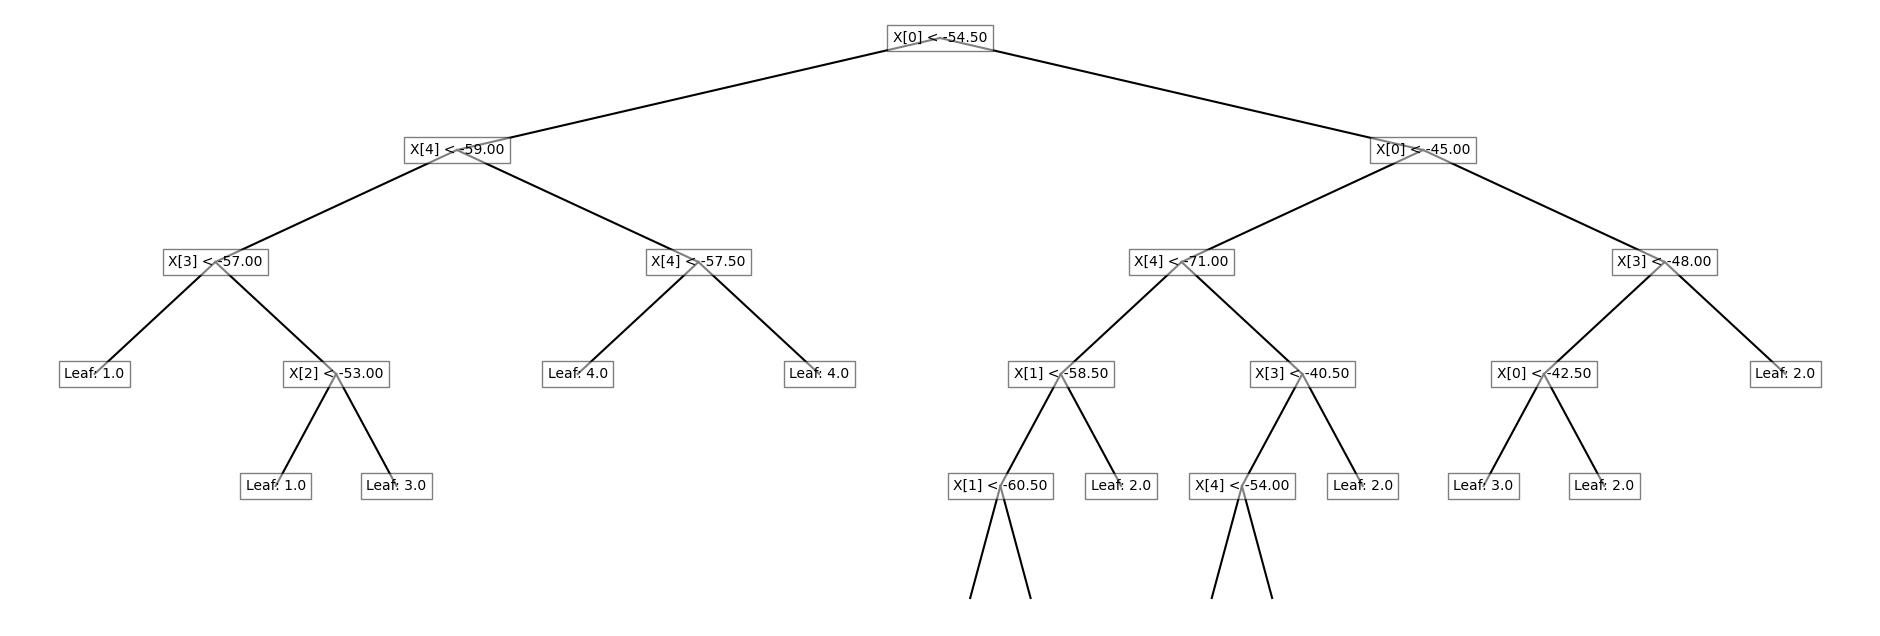

In [15]:
# prune the decision tree
pruned_tree = prune_tree(tree, train_data, validation_data)
visualize_tree(pruned_tree, max_depth=5)

Max Depth: 15


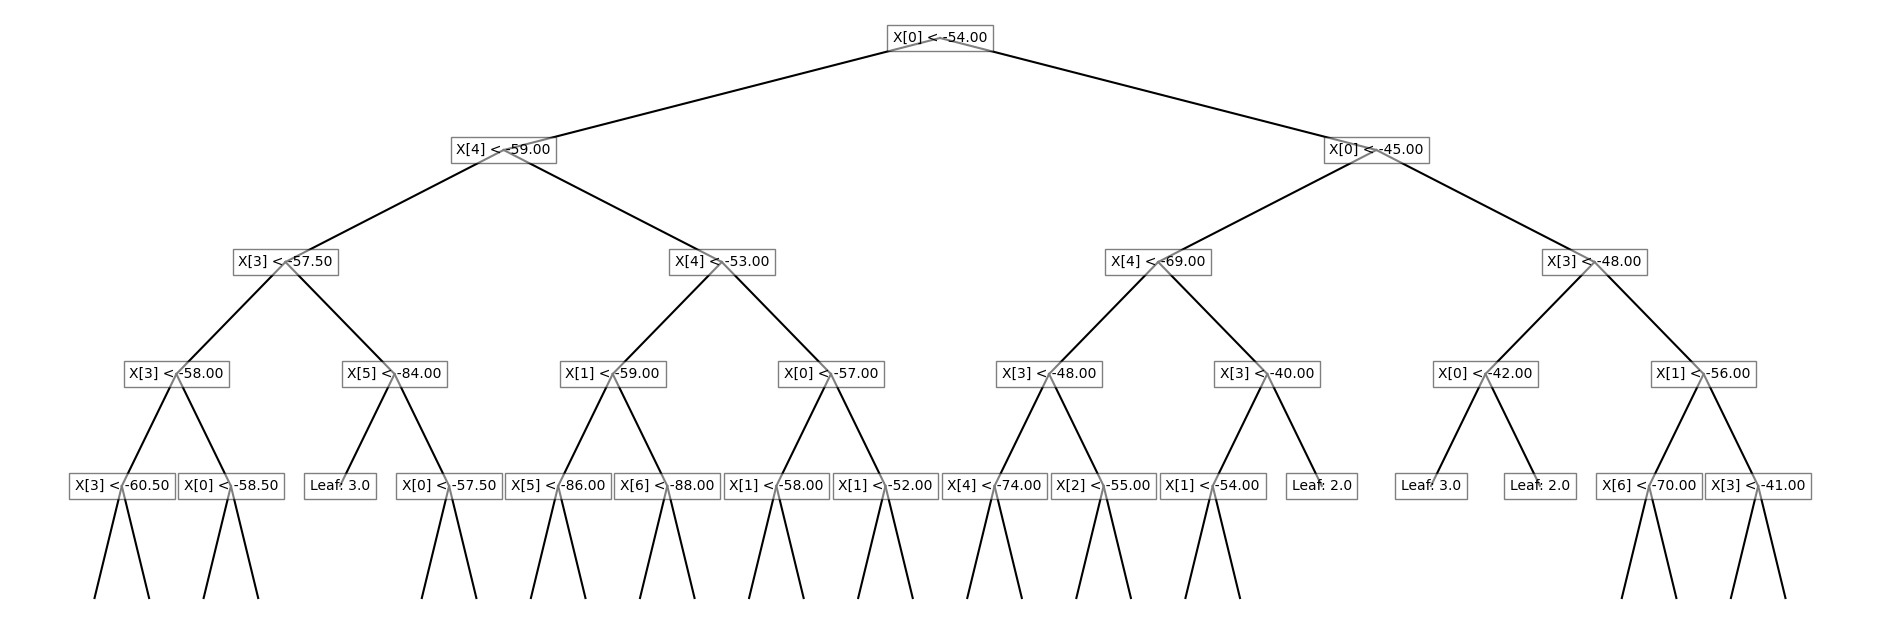

In [16]:
# split the data into training and validation sets
np.random.seed(42)
np.random.shuffle(noisy_data)
train_size = int(0.9 * len(noisy_data))
train_data, validation_data = noisy_data[:train_size], noisy_data[train_size:]

# train the decision tree
tree, max_depth = decision_tree_learning(train_data)
print(f"Max Depth: {max_depth}")
visualize_tree(tree, max_depth=5)

In [17]:
# evaluate the decision tree
# Training accuracy
metrics = evaluate(train_data, tree)
print(f"Training Accuracy: {metrics['accuracy']:.4f}")
print("-"*50)

metrics = evaluate(validation_data, tree)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1: {metrics['f1']}")

Training Accuracy: 0.8811
--------------------------------------------------
Accuracy: 0.8700
Confusion Matrix:
[[42  1  3  1]
 [ 5 40  1  2]
 [ 2  3 50  1]
 [ 4  1  2 42]]
Precision: [0.79245283 0.88888889 0.89285714 0.91304348]
Recall: [0.89361702 0.83333333 0.89285714 0.85714286]
F1: [0.84       0.86021505 0.89285714 0.88421053]


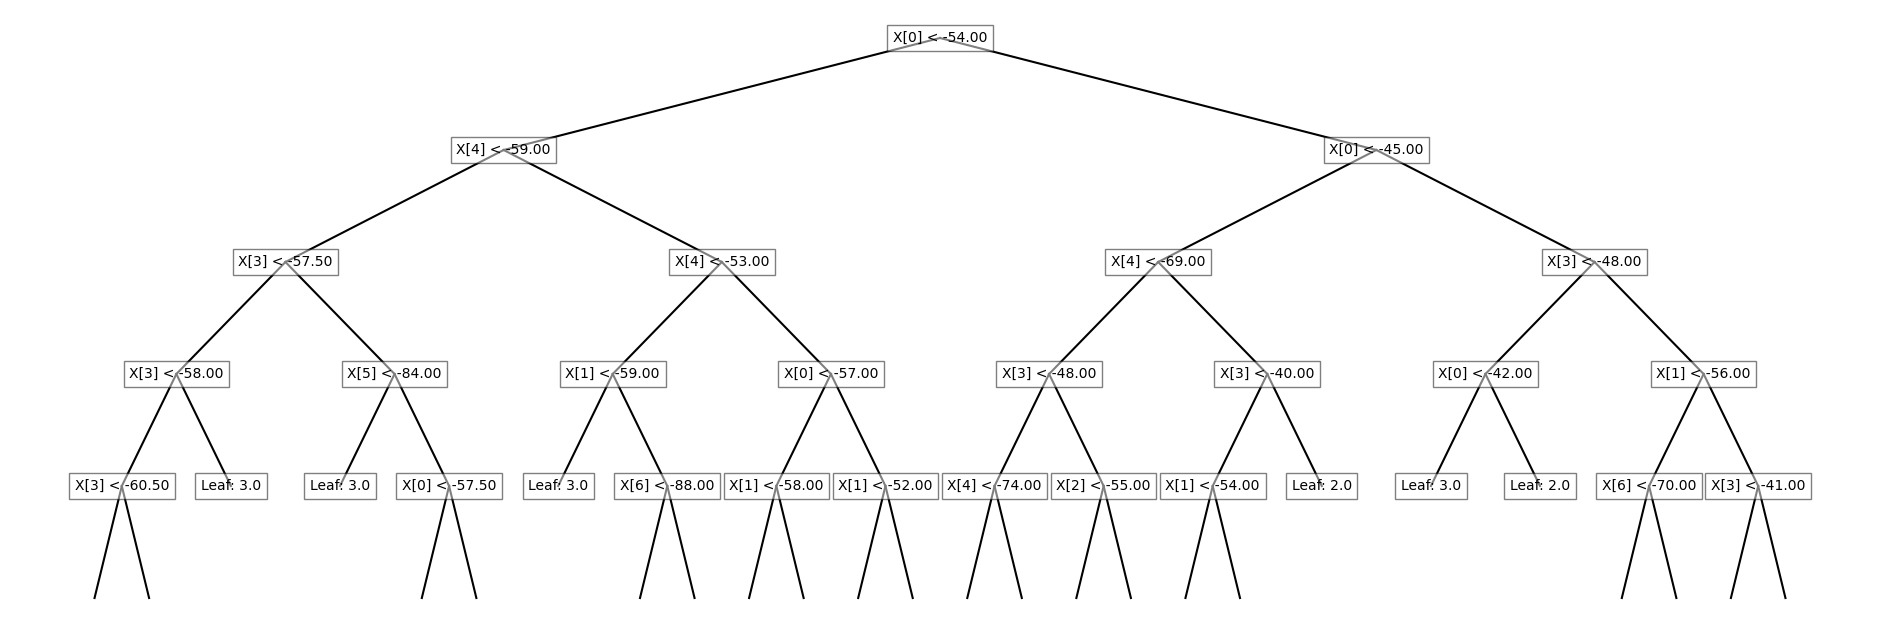

In [18]:
# prune the decision tree
pruned_tree = prune_tree(tree, train_data, validation_data)
visualize_tree(pruned_tree, max_depth=5)

In [19]:
# evaluate the pruned decision tree
metrics = evaluate(validation_data, pruned_tree)
print(f"Accuracy_pruned: {metrics['accuracy']:.2f}")
print(f"Confusion Matrix_pruned:\n{metrics['confusion_matrix']}")
print(f"Precision_pruned: {metrics['precision']}")
print(f"Recall_pruned: {metrics['recall']}")
print(f"F1_pruned: {metrics['f1']}")


Accuracy_pruned: 0.87
Confusion Matrix_pruned:
[[42  1  3  1]
 [ 4 40  2  2]
 [ 2  3 50  1]
 [ 4  1  2 42]]
Precision_pruned: [0.80769231 0.88888889 0.87719298 0.91304348]
Recall_pruned: [0.89361702 0.83333333 0.89285714 0.85714286]
F1_pruned: [0.84848485 0.86021505 0.88495575 0.88421053]


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Prepare the training and validation data
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = validation_data[:, :-1], validation_data[:, -1]

# Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Training accuracy
y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy_sklearn: {accuracy_train:.2f}")

# Predict the labels for the validation data
y_pred = clf.predict(X_val)

# Evaluate the classifier
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
precision = precision_score(y_val, y_pred, average=None)
recall = recall_score(y_val, y_pred, average=None)
f1 = f1_score(y_val, y_pred, average=None)

# Print the evaluation metrics
print(f"Accuracy_sklearn: {accuracy:.2f}")
print(f"Confusion Matrix_sklearn:\n{conf_matrix}")
print(f"Precision_sklearn: {precision}")
print(f"Recall_sklearn: {recall}")
print(f"F1_sklearn: {f1}")

Training Accuracy_sklearn: 1.00
Accuracy_sklearn: 0.80
Confusion Matrix_sklearn:
[[37  2  2  6]
 [ 3 34  3  8]
 [ 0  5 49  2]
 [ 8  0  2 39]]
Precision_sklearn: [0.77083333 0.82926829 0.875      0.70909091]
Recall_sklearn: [0.78723404 0.70833333 0.875      0.79591837]
F1_sklearn: [0.77894737 0.76404494 0.875      0.75      ]
